In [ ]:
!pip install tweepy

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from_selection import train_test_split sklearn.model
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load Tweet dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Data_small.csv')
# Output first five rows
df.head()

In [ ]:
# Check for missing data
df.isnull().sum()

clean_text    1
category      0
dtype: int64

In [ ]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [ ]:
# dimensionality of the data
df.shape

(9997, 2)

In [ ]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


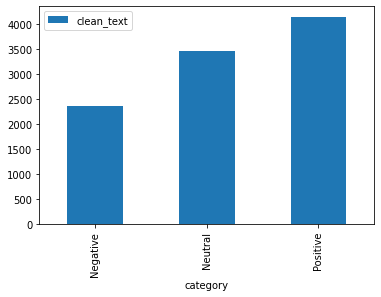

In [ ]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

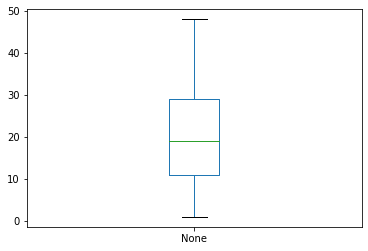

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

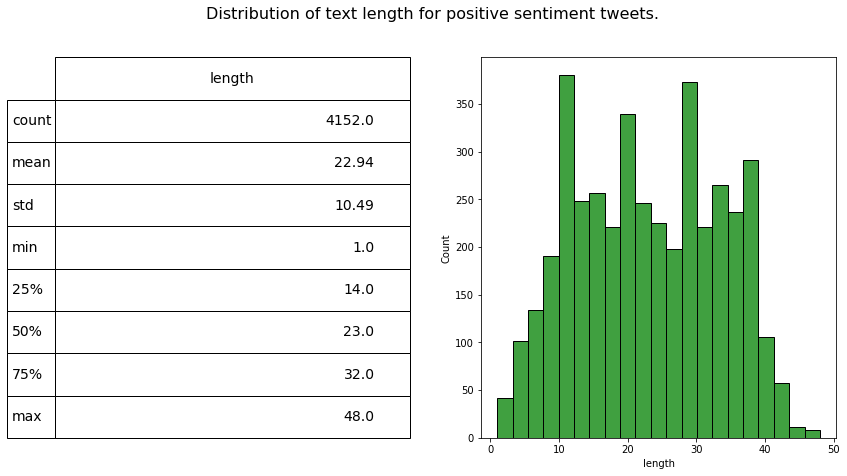

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

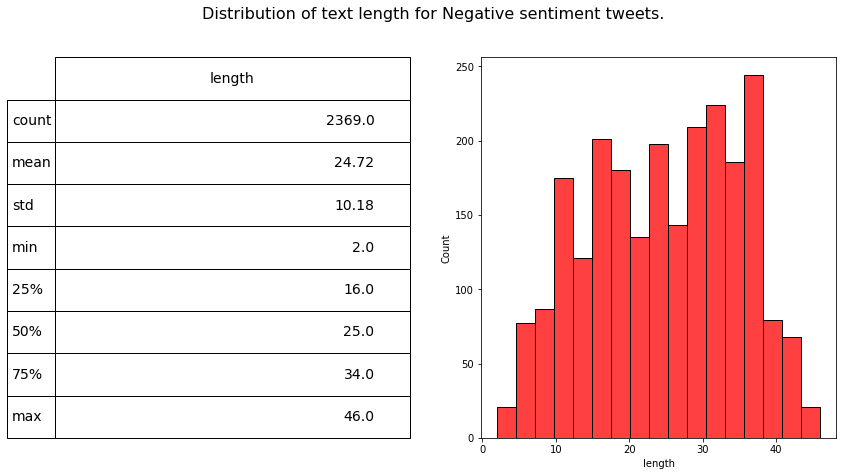

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [ ]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

    # Positive tweet words
    wordcount_gen(df, 'Positive')

    # Negative tweet words
    wordcount_gen(df, 'Negative')

    # Neutral tweet words
    wordcount_gen(df, 'Neutral')


In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print('Number of tweets in the total set : {}'.format(len(X)))
print('Number of tweets in the training set : {}'.format(len(X_train)))
print('Number of tweets in the testing set : {}'.format(len(X_test)))

Number of tweets in the total set : 9997
Number of tweets in the training set : 7997
Number of tweets in the testing set : 2000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


vocabulary_size = 500

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                                  
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['100', '2014', '2019', '6000', '72000', 'aap', 'abus', 'accept', 'account', 'achiev', 'act', 'action', 'actual', 'adani', 'agenda', 'agre', 'air', 'allow', 'alreadi', 'also', 'alway', 'ambani', 'amit', 'amount', 'announc', 'anoth', 'answer', 'anti', 'anyon', 'anyth', 'app', 'appeal', 'armi', 'ask', 'attack', 'awar', 'away', 'back', 'bad', 'bank', 'base', 'becom', 'behind', 'believ', 'benefit', 'best', 'better', 'bhakt', 'bharat', 'bhi', 'big', 'biggest', 'biopic', 'bjp', 'black', 'blame', 'board', 'bring', 'brother', 'brought', 'budget', 'busi', 'buy', 'call', 'came', 'campaign', 'candid', 'cannot', 'cant', 'card', 'care', 'case', 'cast', 'chanc', 'chang', 'china', 'choic', 'choos', 'chor', 'chowkidar', 'citizen', 'claim', 'class', 'clean', 'clear', 'code', 'come', 'commiss', 'common', 'commun', 'compani', 'compar', 'complet', 'cong', 'congress', 'contest', 'continu', 'corrupt', 'cost', 'could', 'countri', 'court', 'creat', 'credit', 'critic', 'croni', 'crore', 'data', 'day', 'deal', 

In [ ]:
from sklearn import svm
# classify using support vector classifier
svm = svm.SVC(kernel = 'linear', probability=True)

# fit the SVC model based on the given training data
prob = svm.fit(X_train, y_train).predict_proba(X_test)

# perform classification and prediction on samples in x_test
y_pred_svm = svm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score:", accuracy_score(y_test, y_pred_svm) * 100, '%')

Accuracy score: 69.55 %
